# Processing the Clams Data

In [2]:
import os
import glob
import math as m
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import statsmodels.api as sm

import scipy as sc
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import seaborn as sns
import itertools
import sklearn
import re

In [3]:
#Identify the main data frame being used
clams2 = pd.read_csv("/Users/kenneth/Desktop/repro_database-main/piv_clams.csv")
print("Shape:", clams2.shape)
print("Features:", list(clams2.columns))
clams2 = clams2.fillna(0)
clams2 = clams2.drop(columns = ['Notes', 'Unnamed: 18'])
clams2.head(3)
#Temp: Celcius, Chlorophyll: mg/L, Salinity: Practical Salinity Units (PSU) in parts per thousand (ppt)

Shape: (9822, 24)
Features: ['SiteID', 'Study', 'Species', 'Locality', 'LatDeg', 'LatMin', 'LongDeg', 'LongMin', 'spawnstart', 'spawnend', 'peak1', 'spawnstart2', 'spawnend2', 'peak2', 'spawnstart3', 'spawnend3', 'peak3', 'Notes', 'Unnamed: 18', 'Normalized Date', 'Chlorophyll', 'Salinity', 'Temperature', 'Family']


,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,spawnend2,peak2,spawnstart3,spawnend3,peak3,Normalized Date,Chlorophyll,Salinity,Temperature,Family
0,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,28.783536,0.0,Veneridae
1,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,28.819698,0.0,Veneridae
2,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,35.105508,0.0,Veneridae


## Provided Features Descriptions:
- **SiteID**: ID number correlated to the study the information was extracted from.
- **Study**: The Author's last name and the year the study was done.
- **Species**: Contains the taxonomic *Genus* and *Species* name of the bivalve. 
- **Locality**: Unoffical location the study has taken place.
- **LatDeg, LatMin**: The Lattitude Degree and Minute of the study's location in respective order
- **LongDeg, LongMin**: The Longitude Degree and Minute of the study's location in respective order
- **spawnstart, spawnstart2, spawnstart3**: The starting month of each spawn cycle (2/3 exist for species that spawn multiple times a year).
- **spawnend, spawnend2, spawnend3**: The ending month of each spawn cycle (2/3 exist for species that spawn multiple times a year).
- **peak1, peak2, peak3**: The peak month of the corresponding cycle (2/3 exist only for some species that spawn multiple times a year).
- **Normalized Date**: The date value where 1 is considered a year. 
- **Chlorophyll**: The milligrams concentration of Chlorophyll in a Liter of water
- **Salinity**: The Practical Salinity Units (PSU) in parts per thousand (ppt).
- **Temperature**: The Degrees Celcius of the water.
- **Family**: The taxonomic family that each species belongs in.
- **Dropped columns (Notes, Unnamed: 18)**: Notes with small descriptions

In [4]:
#Find clams that has at least 1 Data_Type value

clams2 = clams2[(clams2["Chlorophyll"] != 0) | (clams2["Salinity"] != 0) | (clams2["Temperature"] != 0)]
clams2.sort_values('Species')
clams2.reset_index()
print(clams2.shape)
clams2.tail(3)

(9379, 22)


,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,spawnend2,peak2,spawnstart3,spawnend3,peak3,Normalized Date,Chlorophyll,Salinity,Temperature,Family
9626,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.832143,0.0,0.0,25.898,Pinnidae
9627,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.917857,0.0,0.0,21.254,Pinnidae
9628,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.0,0.0,0.0,1.085714,0.0,0.0,18.967,Pinnidae


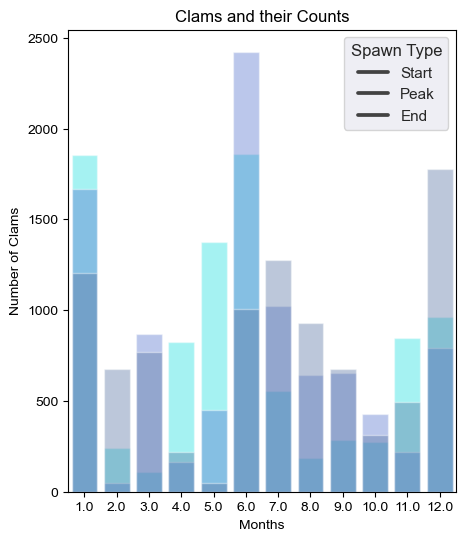

In [5]:
#Peak spawn of clams graphs
clams_spawn1 = clams2.groupby(['spawnstart'])['spawnstart'].count()
clams_spawn1 = clams_spawn1.to_frame('Spawn Start')
clams_spawn1['type'] = [0] * len(clams_spawn1)


clams_peak1 = clams2.groupby(['peak1'])['peak1'].count()
clams_peak1 = clams_peak1.to_frame('Spawn Peak')
clams_peak1['type'] = [0] * len(clams_peak1)

clams_end1 = clams2.groupby(['spawnend'])['spawnend'].count()
clams_end1 = clams_end1.to_frame('Spawn End')
clams_end1['type'] = [0] * len(clams_end1)

f, ax = plt.subplots(figsize=(5,6))
sns.set()
ax = sns.barplot(data = clams_spawn1, x= clams_spawn1.index, y= 'Spawn Start', color = 'aqua', alpha = 0.4)
ax = sns.barplot(data = clams_peak1, x= clams_peak1.index, y= 'Spawn Peak', color = 'royalblue', alpha = 0.4)
ax = sns.barplot(data = clams_end1, x= clams_end1.index, y= 'Spawn End', color = 'b', alpha = 0.4)

plt.title('Clams and their Counts')
plt.xlabel('Months')
plt.ylabel('Number of Clams')
plt.legend(title='Spawn Type', loc='upper right', labels=['Start', 'Peak', 'End'])
plt.show()

Let's just look at one of the speices that has multiple indicators:

In [6]:
laternula = clams2[clams2['Species'] == 'Laternula elliptica']
laternula = laternula.loc[:, ['Species', 'Normalized Date', 'Chlorophyll', 'Salinity', 'Temperature']]
laternula.head()

,Species,Normalized Date,Chlorophyll,Salinity,Temperature
10,Laternula elliptica,0.000008,0.924888,0.0,0.000000
11,Laternula elliptica,0.001134,0.000000,0.0,1.515878
12,Laternula elliptica,0.001248,0.000000,0.0,1.610992
13,Laternula elliptica,0.001345,1.009171,0.0,0.000000
14,Laternula elliptica,0.003402,0.000000,0.0,1.296380


Let's make the dates more readable and focus on a single species for simplicity:

In [7]:
laternula["Normalized Date"] = [m.floor(i * 365) for i in laternula["Normalized Date"]]
laternula = laternula.rename(columns= {"Normalized Date": "Days"})

Now, I want to simplify the data by grouping each value into a day and averaging the values.

In [8]:
laternula['Chlorophyll'] = laternula['Chlorophyll'].replace(0, np.NaN)
laternula['Salinity'] = laternula['Salinity'].replace(0, np.NaN)
laternula['Temperature'] = laternula['Temperature'].replace(0, np.NaN)
laternula
# laternula.groupby(laternula['Days']).

,Species,Days,Chlorophyll,Salinity,Temperature
10,Laternula elliptica,0,0.924888,NaN,NaN
11,Laternula elliptica,0,NaN,NaN,1.515878
12,Laternula elliptica,0,NaN,NaN,1.610992
13,Laternula elliptica,0,1.009171,NaN,NaN
14,Laternula elliptica,1,NaN,NaN,1.296380
...,...,...,...,...,...
738,Laternula elliptica,391,0.593407,NaN,NaN
739,Laternula elliptica,392,0.551569,NaN,NaN
740,Laternula elliptica,392,0.508413,NaN,NaN
741,Laternula elliptica,396,NaN,NaN,1.842188


In [9]:
lat_simple = laternula.groupby(["Species", "Days"]).mean()
lat_simple = lat_simple.fillna(0)
lat_simple = lat_simple.reset_index()
lat_simple

,Species,Days,Chlorophyll,Salinity,Temperature
0,Laternula elliptica,0,0.967029,0.0,1.563435
1,Laternula elliptica,1,0.971320,0.0,1.316822
2,Laternula elliptica,2,0.926799,0.0,0.000000
3,Laternula elliptica,3,0.000000,0.0,1.420799
4,Laternula elliptica,4,0.000000,0.0,1.561987
...,...,...,...,...,...
310,Laternula elliptica,390,0.804621,0.0,1.941360
311,Laternula elliptica,391,0.657575,0.0,1.848116
312,Laternula elliptica,392,0.529991,0.0,0.000000
313,Laternula elliptica,396,0.000000,0.0,1.842188


Let's figure out where the spawn start, end, and peak is at:

In [10]:
lat_spawns = clams2[clams2["Species"] == 'Laternula elliptica'].iloc[0, 8:11]
lat_spawns = [m.floor(i) for i in lat_spawns.values / 12 *365]

Plot the graph to see how the temperature changes over the days.

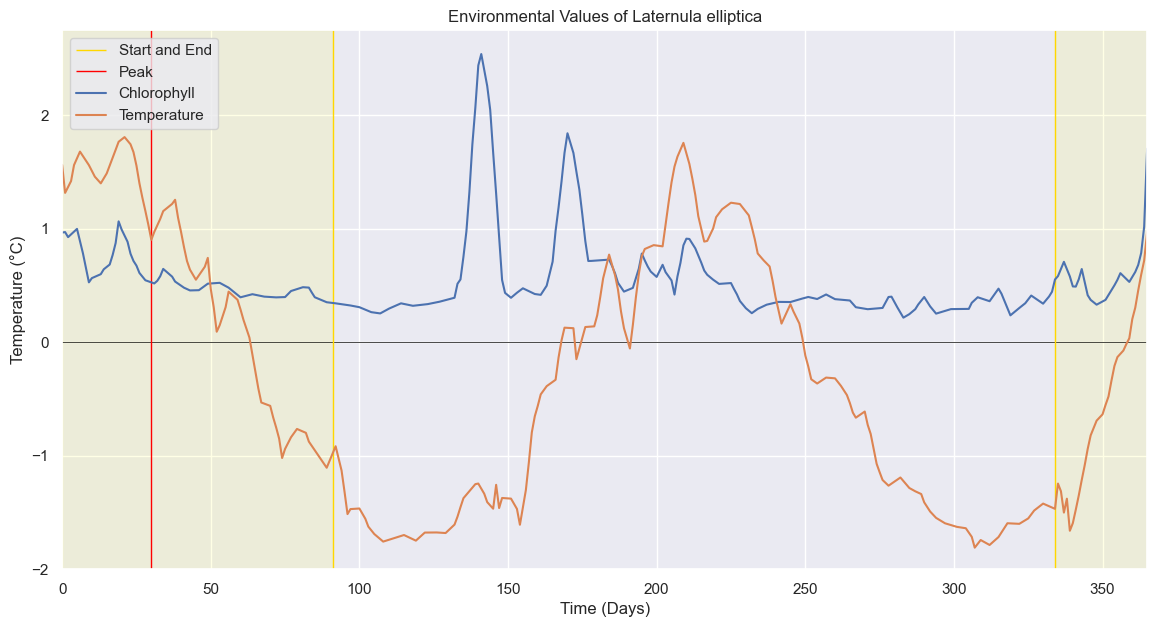

In [11]:
f, ax = plt.subplots(figsize=(14, 7))

ax.axhline(linewidth= 0.5, color='black');
ax.vlines(lat_spawns[0:2],-2, 2.75, linewidth= 1, color='gold', label= 'Start and End')
ax.vlines(lat_spawns[2],-2, 2.75, linewidth= 1, color='red', label= 'Peak')
plt.axvspan(0, lat_spawns[1], color='yellow', alpha=0.1)
plt.axvspan(lat_spawns[0], 497, color='yellow', alpha=0.1)

lat_simple_chl = lat_simple[lat_simple["Chlorophyll"] != 0]
lat_simple_temp = lat_simple[lat_simple["Temperature"] != 0]
ax.plot("Days", "Chlorophyll", data = lat_simple_chl)
ax.plot("Days", "Temperature", data = lat_simple_temp)

plt.legend(title='Env Value', loc='upper right', labels=['Chlorophyll', 'Temperature'])
plt.legend()
ax.title.set_text('Environmental Values of Laternula elliptica')
plt.ylim([-2, 2.75])
plt.xlim([0, 365])
plt.xlabel('Time (Days)')
plt.ylabel('Temperature (°C)')
plt.savefig('Laternula.png');

This shows us the breeding season, for the year. It seems that the values follow a general trend of ocean climates. The data does bleeds into next year. Let's look at the general data more and use month values also.

In [12]:
clams2_fix = clams2
months = clams2_fix['Normalized Date'] * 12
months = [m.floor(month) for month in months]
days = clams2_fix['Normalized Date'] * 365
days = [m.floor(day) for day in days]
years = clams2_fix['Normalized Date']
years = [m.floor(year) for year in years]
clams2_fix.loc[:, ['Month']] = months
clams2_fix.loc[:, ['Day']] = days
clams2_fix.loc[:, ['Year']] = years
clams2_fix

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,spawnend3,peak3,Normalized Date,Chlorophyll,Salinity,Temperature,Family,Month,Day,Year
0,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,4.000000,0.0,28.783536,0.000,Veneridae,48,1460,4
1,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,5.000000,0.0,28.819698,0.000,Veneridae,60,1825,5
2,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,6.000000,0.0,35.105508,0.000,Veneridae,72,2190,6
3,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,7.000000,0.0,33.390196,0.000,Veneridae,84,2555,7
4,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,0.0,8.000000,0.0,34.424729,0.000,Veneridae,96,2920,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9624,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.582143,0.0,0.000000,30.868,Pinnidae,6,212,0
9625,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.664286,0.0,0.000000,29.865,Pinnidae,7,242,0
9626,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.832143,0.0,0.000000,25.898,Pinnidae,9,303,0
9627,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.0,0.0,0.917857,0.0,0.000000,21.254,Pinnidae,11,335,0


Quickly add how many spawns the clams have:

In [13]:
def create_spawn_times(data):
    abc = []
    for i in range(len(data)):
        spawns = 0
        if data.iloc[i, 10] != 0:
            spawns += 1
            if  data.iloc[i, 13] != 0:
                spawns += 1
                if  data.iloc[i, 16] != 0:
                    spawns += 1
        abc.append(spawns) 
    data.loc[:, ['NumPeaks']] = abc
    return data

clams2_fix = create_spawn_times(clams2_fix)
clams2_fix.head()

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,peak3,Normalized Date,Chlorophyll,Salinity,Temperature,Family,Month,Day,Year,NumPeaks
0,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,4.0,0.0,28.783536,0.0,Veneridae,48,1460,4,1
1,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,5.0,0.0,28.819698,0.0,Veneridae,60,1825,5,1
2,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,6.0,0.0,35.105508,0.0,Veneridae,72,2190,6,1
3,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,7.0,0.0,33.390196,0.0,Veneridae,84,2555,7,1
4,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,0.0,8.0,0.0,34.424729,0.0,Veneridae,96,2920,8,1


Create a new column for the region of the world that each study takes place in.

In [14]:
def regex_country(data):
    countries = []
    for i in range(len(data)):
        re_land = r'[^,]*$'
        land = re.search(re_land, data.iloc[i, 3])
        if land is not None:
            if re.search(r' ', land.group()[0]) is None:
                countries.append(land.group())
            else:
                countries.append(land.group()[1:])
        else:
            countries.append(data.iloc[i, 3])
    data.loc[:, "Country"] = countries
    return data
clams2_fix = regex_country(clams2_fix)
clams2_fix = clams2_fix.replace("Hackett's Bar", 'Canada')
clams2_fix = clams2_fix.replace("Kames Bay", 'United Kingdom')
clams2_fix = clams2_fix.replace("Whitstable UK", 'United Kingdom')
clams2_fix = clams2_fix.replace("NSW", 'Australia')
clams2_fix = clams2_fix.replace("Langstone Harbor", 'United Kingdom')
clams2_fix = clams2_fix.replace("Scotland", 'United Kingdom')
clams2_fix = clams2_fix.replace("Loch Etive", 'United Kingdom')
clams2_fix = clams2_fix.replace("NZ", 'New Zealand')
clams2_fix = clams2_fix.replace("Baie des Veys ", 'France')
clams2_fix = clams2_fix.replace("Marennes-Oleron", 'France')
clams2_fix = clams2_fix.replace("Venice Lagoon", 'Italy')
clams2_fix = clams2_fix.replace("Bahia de Guaymas-Empalme", 'Mexico')
clams2_fix = clams2_fix.replace("Baja California Sur", 'Mexico')
clams2_fix = clams2_fix.replace("Northern Sea of Marmara", 'Turkey')
clams2_fix = clams2_fix.replace("FL", 'Florida, USA')
clams2_fix = clams2_fix.replace("Florida", 'Florida, USA')
clams2_fix = clams2_fix.replace("SC", 'South Carolina, USA')
clams2_fix = clams2_fix.replace("NC", 'North Carolina, USA')
clams2_fix = clams2_fix.replace("CT", 'Connecticut, USA')
clams2_fix = clams2_fix.replace("NY", 'New York, USA')
clams2_fix = clams2_fix.replace("NJ", 'New Jersey, USA')
clams2_fix = clams2_fix.replace("Washington", 'Washington, USA')
clams2_fix = clams2_fix.replace("False Bay", 'South Africa')
clams2_fix = clams2_fix.replace("Spain ", 'Spain')
clams2_fix = clams2_fix.replace("Port of San Carlos", 'Philippines')
clams2_fix = clams2_fix.replace("Adyar river mouth", 'India')
clams2_fix = clams2_fix.replace("Mali Ston Bay", 'Croatia')
clams2_fix.head()

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Normalized Date,Chlorophyll,Salinity,Temperature,Family,Month,Day,Year,NumPeaks,Country
0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,4.0,0.0,28.783536,0.0,Veneridae,48,1460,4,1,India
1,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,5.0,0.0,28.819698,0.0,Veneridae,60,1825,5,1,India
2,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,6.0,0.0,35.105508,0.0,Veneridae,72,2190,6,1,India
3,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,7.0,0.0,33.390196,0.0,Veneridae,84,2555,7,1,India
4,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,8.0,0.0,34.424729,0.0,Veneridae,96,2920,8,1,India


Separate Countries by Hemisphere to get the Temperature data consistent.

In [15]:
hemisphere_dict = {"North": ['India', 'Canada', 'Portugal', 'United Kingdom', 'France',
       'Mexico', 'Pakistan', 'Iran', 'South Carolina, USA', 'Italy', 'Sweden',
       'Norway', 'Ireland', 'Croatia', 'Turkey', 'Tunisia', 'Saudi Arabia',
       'Florida, USA', 'North Carolina, USA', 'Connecticut, USA', 'New York, USA',
       'Argentina', 'Korea', 'Japan', 'Georgia', 'New Jersey, USA', 'China',
       'Washington, USA', 'Philippines', 'Senegal', 'Jamaica', 'Spain',
       'Morocco', 'Iceland', 'USA', 'Sierra Leone', 'Malaysia'], 
              "South": ['Antarctica','South Africa', 'Chile', 'New Zealand',
       'Australia']}
hemis = []
for country in clams2_fix["Country"]:
    if country in hemisphere_dict['North']:
        hemis.append('North')
    elif country in hemisphere_dict['South']:
        hemis.append('South')
    else:
        hemis.append(0.0)
clams2_fix.loc[:, "Hemisphere"] = hemis
clams2_fix[clams2_fix['Hemisphere'] == 0]

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Chlorophyll,Salinity,Temperature,Family,Month,Day,Year,NumPeaks,Country,Hemisphere


Let's also look at the amount of time each spawning windown is:

In [16]:
clams2_fix.columns

Index(['SiteID', 'Study', 'Species', 'Locality', 'LatDeg', 'LatMin', 'LongDeg',
       'LongMin', 'spawnstart', 'spawnend', 'peak1', 'spawnstart2',
       'spawnend2', 'peak2', 'spawnstart3', 'spawnend3', 'peak3',
       'Normalized Date', 'Chlorophyll', 'Salinity', 'Temperature', 'Family',
       'Month', 'Day', 'Year', 'NumPeaks', 'Country', 'Hemisphere'],
      dtype='object')

In [17]:
def spawning_windows(data, start_num, end_num, cycle_num):
    windows = []
    for i in range(len(data)):
        length = 0
        start = data.iloc[i, start_num]
        stop = data.iloc[i, end_num]
        if start > stop:
            length += (12 - start) + stop
        elif (start == stop) and (start != 0) and (stop != 0):
            length = 12
        else:
            length = stop - start
        windows.append(int(length))
    data.loc[:, ["Spawn Len " + cycle_num]] = windows
    return data
clams2_fix = spawning_windows(clams2_fix, 8, 9, '1')
clams2_fix = spawning_windows(clams2_fix, 11, 12, '2')
clams2_fix = spawning_windows(clams2_fix, 14, 15, '3')
clams2_fix

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Family,Month,Day,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3
0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,Veneridae,48,1460,4,1,India,North,6,0,0
1,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,Veneridae,60,1825,5,1,India,North,6,0,0
2,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,Veneridae,72,2190,6,1,India,North,6,0,0
3,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,Veneridae,84,2555,7,1,India,North,6,0,0
4,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,Veneridae,96,2920,8,1,India,North,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9624,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,Pinnidae,6,212,0,1,Mexico,North,9,0,0
9625,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,Pinnidae,7,242,0,1,Mexico,North,9,0,0
9626,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,Pinnidae,9,303,0,1,Mexico,North,9,0,0
9627,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,Pinnidae,11,335,0,1,Mexico,North,9,0,0


Now, let's also classify the clams into Lattitude zones.

In [18]:
def lat_zones(data):
    zones = []
    for i in range(len(data)):
        lat = data.iloc[i, 4]
        if lat > -22.5 and lat < 22.5:
            zones.append('Tropical')
        elif (lat < -22.5 and lat >= -45) or (lat > 22.5 and lat <= 45):
            zones.append('Subtropical')
        elif (lat < -45 and lat >= -67.5) or (lat > 45 and lat <= 67.5):
            zones.append('Temperate')
        elif (lat < -67.5 and lat >= -90) or (lat > 67.5 and lat <= 90):
            zones.append('Boreal')
    data.loc[:, 'Lat Zones'] = zones
    return data
clams2_fix = lat_zones(clams2_fix)
clams2_fix.head()

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Month,Day,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones
0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,48,1460,4,1,India,North,6,0,0,Tropical
1,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,60,1825,5,1,India,North,6,0,0,Tropical
2,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,72,2190,6,1,India,North,6,0,0,Tropical
3,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,84,2555,7,1,India,North,6,0,0,Tropical
4,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,96,2920,8,1,India,North,6,0,0,Tropical


Let's add the year this data is collected:

In [19]:
def study_year(data):
    years = []
    re_year = r'(\d+)'
    for i in range(len(data)):
        year = re.search(re_year, data.iloc[i, 1])
        if year is not None:
            years.append(int(year.group()))
        else:
            years.append(0)
    data.loc[:, 'Start Year'] = years
    return data
clams2_fix = study_year(clams2_fix)
clams2_fix

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Day,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year
0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,1460,4,1,India,North,6,0,0,Tropical,1953
1,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,1825,5,1,India,North,6,0,0,Tropical,1953
2,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,2190,6,1,India,North,6,0,0,Tropical,1953
3,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,2555,7,1,India,North,6,0,0,Tropical,1953
4,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,2920,8,1,India,North,6,0,0,Tropical,1953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9624,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,212,0,1,Mexico,North,9,0,0,Subtropical,2000
9625,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,242,0,1,Mexico,North,9,0,0,Subtropical,2000
9626,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,303,0,1,Mexico,North,9,0,0,Subtropical,2000
9627,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,335,0,1,Mexico,North,9,0,0,Subtropical,2000


Add the Accurate Start Date with Normalization:

In [20]:
acc_yr = clams2_fix.loc[:, 'Start Year'].values + clams2_fix.loc[:, 'Normalized Date'].values
clams2_fix.loc[:, 'Accurate Normalized Date'] = acc_yr
clams2_fix.head(3)

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date
0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,4,1,India,North,6,0,0,Tropical,1953,1957.0
1,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,5,1,India,North,6,0,0,Tropical,1953,1958.0
2,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,6,1,India,North,6,0,0,Tropical,1953,1959.0


## Temperature Data Time

For the temperature data, we cannot assume that the data is isolated and independent. However, Temperature is the most likely factor to be directly affected by global warming, so looking at it is the bset bet in this case.

In [21]:
clams_temp = clams2_fix[clams2_fix["Temperature"] != 0]
print("Species with Temperature Data:", len(clams2_fix['Species'].unique()))

clams_temp_small = clams_temp.loc[:, ['SiteID', 'Species', 'spawnstart', 'spawnend', 'peak1', 'spawnstart2',
       'spawnend2', 'peak2', 'spawnstart3', 'spawnend3', 'peak3', 'Chlorophyll', 'Salinity',
       'Temperature', 'Family', 'Month', 'Day', 'Year', 'NumPeaks', 'Country', 'Hemisphere', 'Spawn Len 1',
       'Spawn Len 2', 'Spawn Len 3', 'Lat Zones', 'Start Year', 'Normalized Date', 'Accurate Normalized Date']]
print(clams_temp_small.shape)
clams_temp_small.head(3)

Species with Temperature Data: 78
(6433, 28)


,SiteID,Species,spawnstart,spawnend,peak1,spawnstart2,spawnend2,peak2,spawnstart3,spawnend3,...,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Normalized Date,Accurate Normalized Date
11,3,Laternula elliptica,11.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,Antarctica,South,4,0,0,Temperate,2003,0.001134,2003.001134
12,3,Laternula elliptica,11.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,Antarctica,South,4,0,0,Temperate,2003,0.001248,2003.001248
14,3,Laternula elliptica,11.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,Antarctica,South,4,0,0,Temperate,2003,0.003402,2003.003402


/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


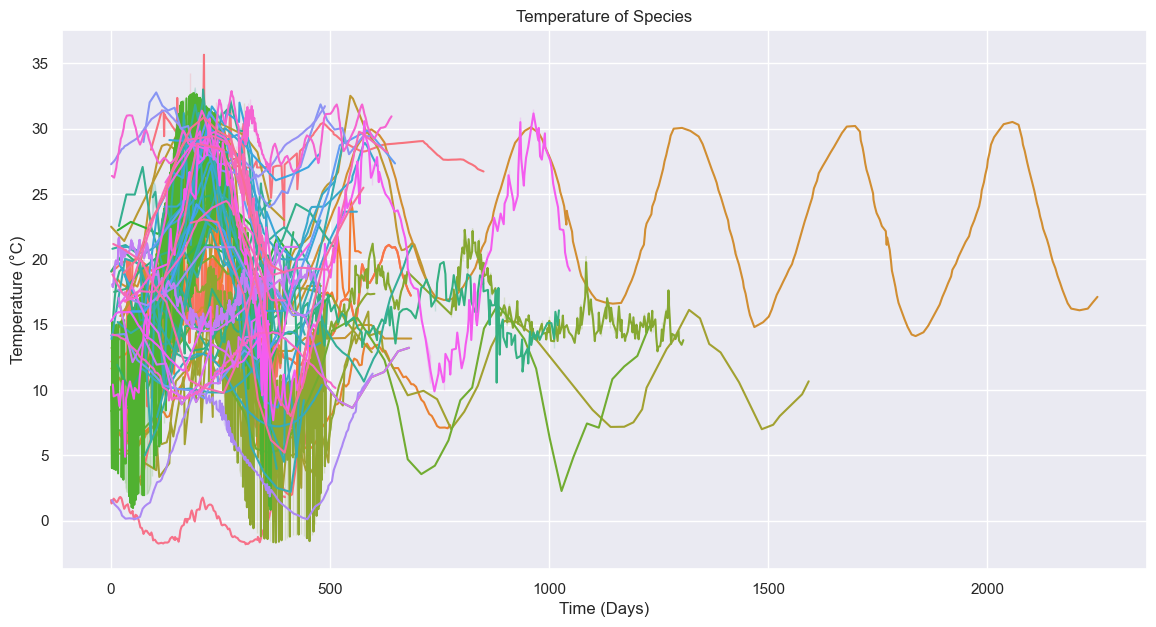

In [22]:
f, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data = clams_temp_small, x = 'Day', y = 'Temperature', hue = "Species" )
ax.title.set_text('Temperature of Species')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature (°C)');
ax.get_legend().set_visible(False)

The data is rediculously messy, but it shows up the species that have long study periods while it also shows us species with frequent data collection.

Mainly we will focus looking at 3 different types of data:
- Long term
- Short term with frequent collection dates (< 7 days between collections)
- Overall, short term data that goes past 1 year

However, the data seemed to be incorrect and the long term data was input incorrectly. Therefore, we will have to adjust our metrics. Therefore, let's just look at the 5 longest data collections excluding the longest line.

In [23]:
longest_collections = clams_temp_small.sort_values('Day', ascending = False)
longest_collections_edited = longest_collections
longest_collections_edited['Species'].unique()

array(['Panopea globosa', 'Modiolus modiolus', 'Argopecten purpuratus',
       'Mya arenaria', 'Astarte borealis', 'Choromytilus meridionalis',
       'Donax faba', 'Venus striatula', 'Crassostrea cucullata',
       'Mesodesma mactroides', 'Pecten sulcicostatus',
       'Crassostrea gigas', 'Ostrea edulis', 'Semele solida',
       'Tagelus dombeii', 'Argopecten circularis', 'Anadara antiquata',
       'Glycymeris gigantea', 'Chione californiensis', 'Macoma balthica',
       'Chlamys islandica', 'Gari solida', 'Crassostrea madrasensis',
       'Scapharca broughtonii', 'Ruditapes decussatus',
       'Solen marginatus', 'Spisula solidissima', 'Anadara trapezia',
       'Brachidontes rodriguezii', 'Megapitaria aurantiaca',
       'Scapharca kagoshimensis', 'Ensis siliqua', 'Donax cuneatus',
       'Hinnites giganteus', 'Acanthocardia tuberculata',
       'Nodipecten subnodosus', 'Crassostrea tulipa', 'Aulacomya atra',
       'Mulinia edulis', 'Perna canaliculus', 'Isognomon alatus',
      

/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


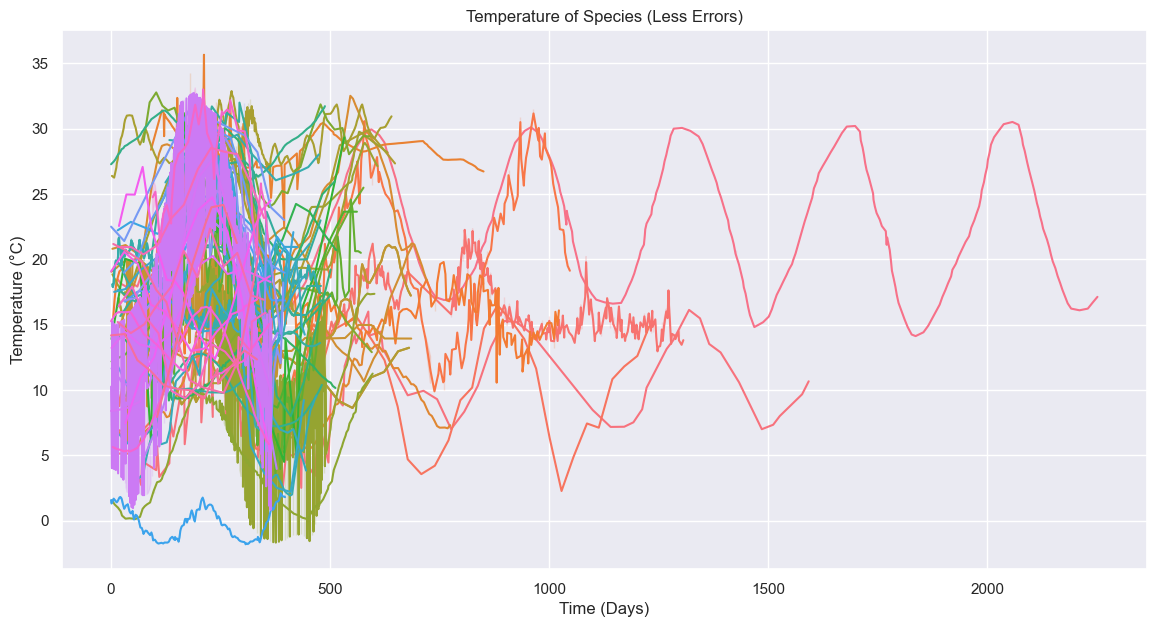

In [24]:
f, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data = longest_collections_edited, x = 'Day', y = 'Temperature', hue = "Species" )
ax.title.set_text('Temperature of Species (Less Errors)')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature (°C)');
ax.get_legend().set_visible(False)

The graph does seem a little ugly still, Let's combine the values as an average on the same day.

In [25]:
longest_collections_edited2 = longest_collections_edited.loc[:, ['Species', 'Day', 'Temperature']].groupby(['Species', 'Day']).mean().reset_index()
longest_collections_edited2.head()

,Species,Day,Temperature
0,Acanthocardia tuberculata,16,17.685185
1,Acanthocardia tuberculata,50,16.851852
2,Acanthocardia tuberculata,82,16.481481
3,Acanthocardia tuberculata,116,17.314815
4,Acanthocardia tuberculata,150,17.962963


In [26]:
longest_collections_edited3 = longest_collections_edited2[longest_collections_edited2['Species'] != "Mercenaria mercenaria"]
longest_collections_edited3 = longest_collections_edited3[longest_collections_edited3["Species"] != 'Macoma balthica']
longest_collections_edited3.head()

,Species,Day,Temperature
0,Acanthocardia tuberculata,16,17.685185
1,Acanthocardia tuberculata,50,16.851852
2,Acanthocardia tuberculata,82,16.481481
3,Acanthocardia tuberculata,116,17.314815
4,Acanthocardia tuberculata,150,17.962963


/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


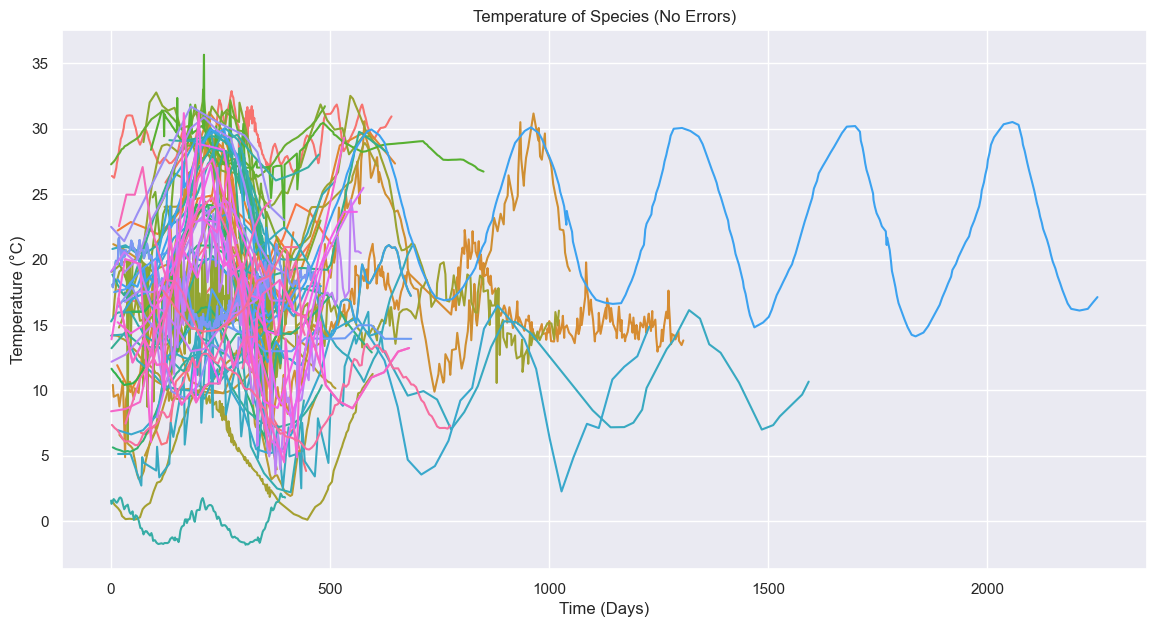

In [27]:
f, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data = longest_collections_edited3, x = 'Day', y = 'Temperature', hue = "Species")
ax.title.set_text('Temperature of Species (No Errors)')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature (°C)');
ax.get_legend().set_visible(False)
plt.savefig('TempAllSpecies.png')

In [28]:
longest5 = longest_collections[longest_collections['Species'].isin(longest_collections_edited['Species'].unique()[:5])]
print(longest5.shape)
longest5.head()

(1076, 28)


,SiteID,Species,spawnstart,spawnend,peak1,spawnstart2,spawnend2,peak2,spawnstart3,spawnend3,...,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Normalized Date,Accurate Normalized Date
3287,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.169382,2016.169382
3286,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.141371,2016.141371
3284,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.108397,2016.108397
3282,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.057438,2016.057438
3281,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.004952,2016.004952


Now, I want to know which family has the most unique points of speices to compare spawning periods within a family.

In [29]:
family_sizes = clams_temp_small.groupby(['Family', 'Species']).count().reset_index().groupby('Family').count()['Species'].sort_values(ascending = False)
family_sizes.head(8)

Family
Veneridae         11
Mytilidae          8
Pectinidae         7
Arcidae            7
Mactridae          6
Donacidae          6
Ostreidae          6
Glycymerididae     2
Name: Species, dtype: int64

Thankfully one of our top 5 are in Mytilidae! We will work with Mytilidae first.

In [30]:
mytilidae = longest_collections_edited[longest_collections_edited["Family"] == 'Mytilidae']
mytilidae_north = mytilidae[mytilidae["Hemisphere"] == 'North']
myt_n_range = mytilidae_north.groupby('Species').first()
mytilidae_south = mytilidae[mytilidae["Hemisphere"] == 'South']
myt_s_range = mytilidae_south.groupby('Species').first()

myt_n_range = myt_n_range.sort_values("SiteID").pivot_table(values= ['peak1', 'spawnend', 'spawnstart'], index='Species')
myt_n_range = myt_n_range.reset_index().melt(id_vars=['Species'], var_name='var_type', value_name='value')
myt_s_range = myt_s_range.sort_values("SiteID").pivot_table(values= ['peak1', 'spawnend', 'spawnstart'], index='Species')
myt_s_range = myt_s_range.reset_index().melt(id_vars=['Species'], var_name='var_type', value_name='value')

/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

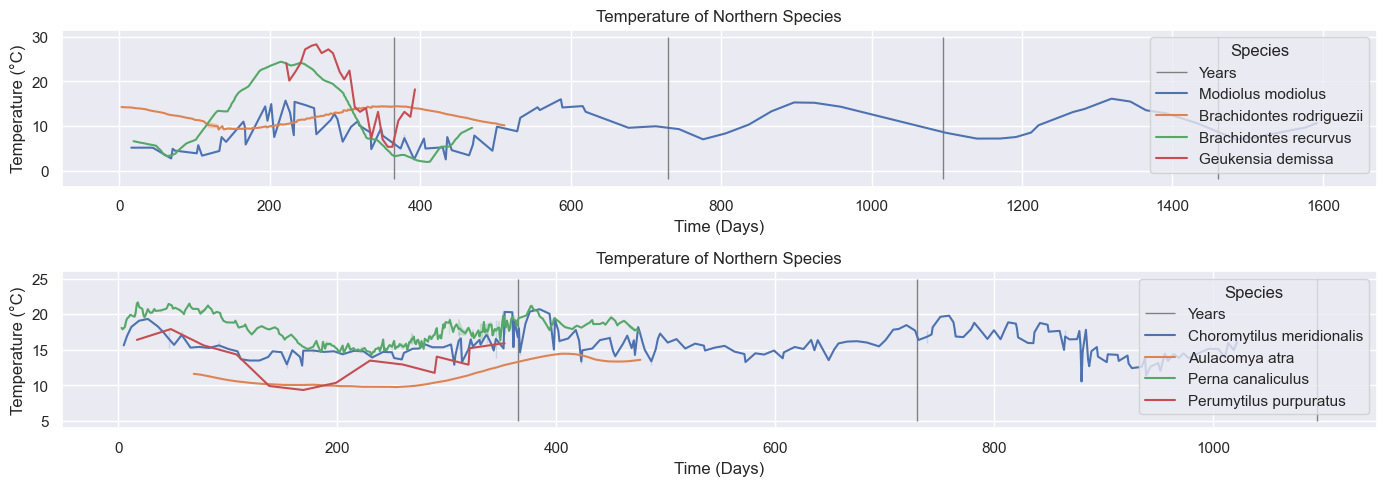

In [31]:
f, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(14, 5))

ax1.vlines([365, 730, 1095, 1460], -2, 30, linewidth= 1, color='grey', label = "Years")
sns.lineplot(ax=ax1, data = mytilidae_north, x = 'Day', y = 'Temperature', hue = "Species" )
ax1.title.set_text('Temperature of Northern Species')
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Temperature (°C)')
ax1.get_legend()
# ax[0].ylim([-1, 30])

ax2.vlines([365, 730, 1095], 5, 25, linewidth= 1, color='grey', label = "Years")
sns.lineplot(ax=ax2, data = mytilidae_south, x = 'Day', y = 'Temperature', hue = "Species" )
ax2.title.set_text('Temperature of Northern Species')
ax2.set_xlabel('Time (Days)')
ax2.set_ylabel('Temperature (°C)')
ax2.get_legend()
# ax[1].ylim([5, 25])

f.tight_layout(pad=1)
plt.savefig('Temp_of_Family_Mytilidae.png');

Looks that the longest species are in different hemispheres. Now, I want to find the spawning ranges for each speices here.

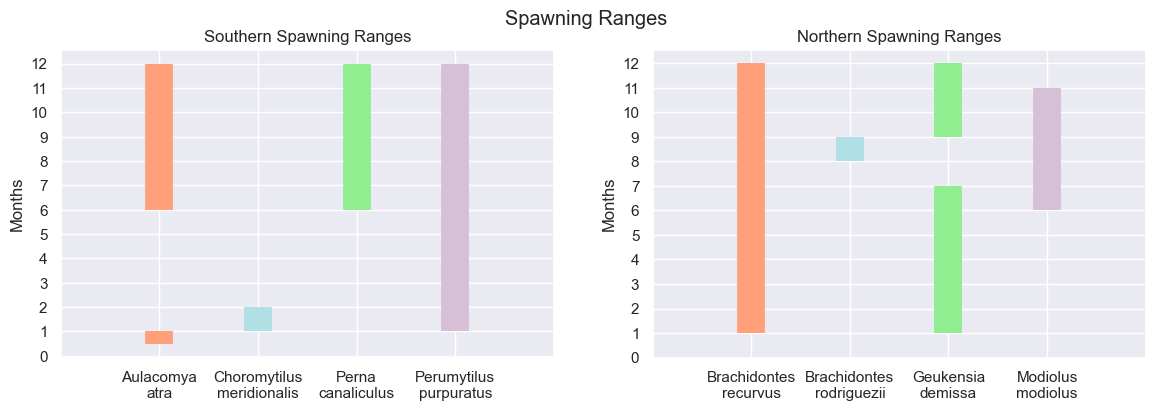

In [32]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot([1, 1], [6, 12], lw=20, color="lightsalmon", solid_capstyle="butt")
ax1.plot([1, 1], [0.5, 1], lw=20, color="lightsalmon", solid_capstyle="butt")
ax1.plot([2, 2], [1, 2], lw=20, color="powderblue", solid_capstyle="butt")
ax1.plot([3, 3], [6, 12], lw=20, color="lightgreen", solid_capstyle="butt")
ax1.plot([4, 4], [1, 12], lw=20, color="thistle", solid_capstyle="butt")
ax1.set_ylabel("Months")
ax1.set_xticks(range(1, 5), ["Aulacomya\natra", "Choromytilus\nmeridionalis", "Perna\ncanaliculus", "Perumytilus\npurpuratus"])
ax1.set_xlim([0, 5])
ax1.set(yticks=(range(13)))
ax1.title.set_text('Southern Spawning Ranges')

ax2.plot([1, 1], [1, 12], lw=20, color="lightsalmon", solid_capstyle="butt")
ax2.plot([2, 2], [8, 9], lw=20, color="powderblue", solid_capstyle="butt")
ax2.plot([3, 3], [9, 12], lw=20, color="lightgreen", solid_capstyle="butt")
ax2.plot([3, 3], [1, 7], lw=20, color="lightgreen", solid_capstyle="butt")
ax2.plot([4, 4], [6, 11], lw=20, color="thistle", solid_capstyle="butt")
ax2.set_ylabel("Months")
ax2.set_xticks(range(1, 5), ["Brachidontes\nrecurvus", "Brachidontes\nrodriguezii", "Geukensia\ndemissa", "Modiolus\nmodiolus"])
ax2.set_xlim([0, 5])
ax2.set(yticks=(range(13)))
ax2.title.set_text('Northern Spawning Ranges')
f.suptitle('Spawning Ranges')
plt.savefig('Spawn_R_Mytilidae.png');

Now the Temperature Ranges:

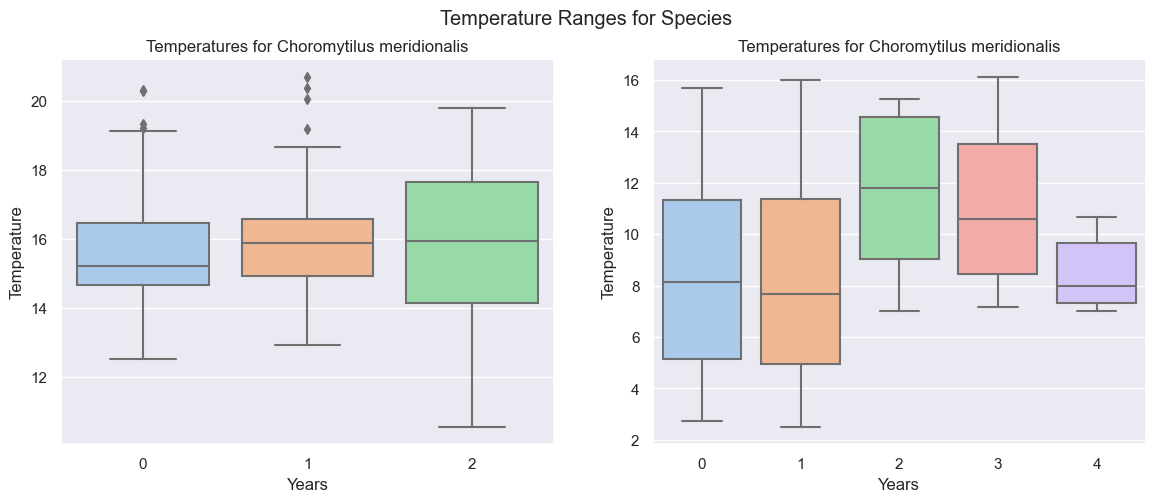

In [33]:
sns.set_palette('pastel')
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(ax = ax1, data = mytilidae[mytilidae["Species"] == 'Choromytilus meridionalis'], x = "Year", y = "Temperature")
ax1.set_xlabel('Years')
ax1.title.set_text('Temperatures for Choromytilus meridionalis')
sns.boxplot(ax = ax2, data = mytilidae[mytilidae["Species"] == 'Modiolus modiolus'], x = "Year", y = "Temperature")
ax2.set_xlabel('Years')
ax2.title.set_text('Temperatures for Choromytilus meridionalis')
f.suptitle('Temperature Ranges for Species')
plt.savefig('Temp_Range_Mytilidae.png');

There is still a lot of variation in data when it comes to the Temperature, Spawning Range, and cycles of data collected. Within each Phylum, there is a good amount of variation. Therefore, looking at species with similar spawning periods might be the way.

In [34]:
print(longest_collections_edited.shape)
longest_collections_edited.head(3)

(6433, 28)


,SiteID,Species,spawnstart,spawnend,peak1,spawnstart2,spawnend2,peak2,spawnstart3,spawnend3,...,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Normalized Date,Accurate Normalized Date
3287,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.169382,2016.169382
3286,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.141371,2016.141371
3284,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.108397,2016.108397


In [35]:
temp_small_spawn_p = longest_collections_edited[longest_collections_edited['Spawn Len 1'] <= 3]
temp_small_spawn_p = temp_small_spawn_p[temp_small_spawn_p['Start Year'] != 0]
print(temp_small_spawn_p.shape)
temp_small_spawn_p.head(3)

(2795, 28)


,SiteID,Species,spawnstart,spawnend,peak1,spawnstart2,spawnend2,peak2,spawnstart3,spawnend3,...,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Normalized Date,Accurate Normalized Date
3287,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.169382,2016.169382
3286,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.141371,2016.141371
3284,49,Panopea globosa,12.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1,Mexico,North,1,0,0,Subtropical,2010,6.108397,2016.108397


/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


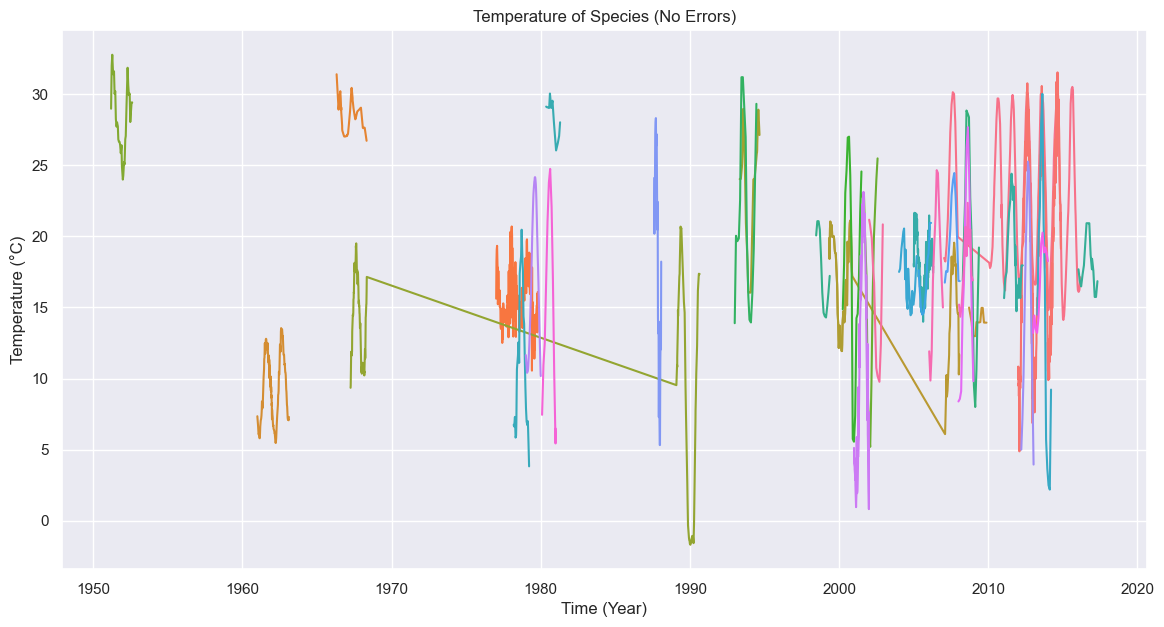

In [36]:
f, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data = temp_small_spawn_p, x = 'Accurate Normalized Date', y = 'Temperature', hue = "Species")
ax.title.set_text('Temperature of Species (No Errors)')
plt.xlabel('Time (Year)')
plt.ylabel('Temperature (°C)');
ax.get_legend().set_visible(False)

Based on the information of the graph, there are a few inconsistencies with the species being connected when they should not be, but it seems even with the low amount of data presented in the mid 1900's, the temperature data has a lot more variation as the times have changed.

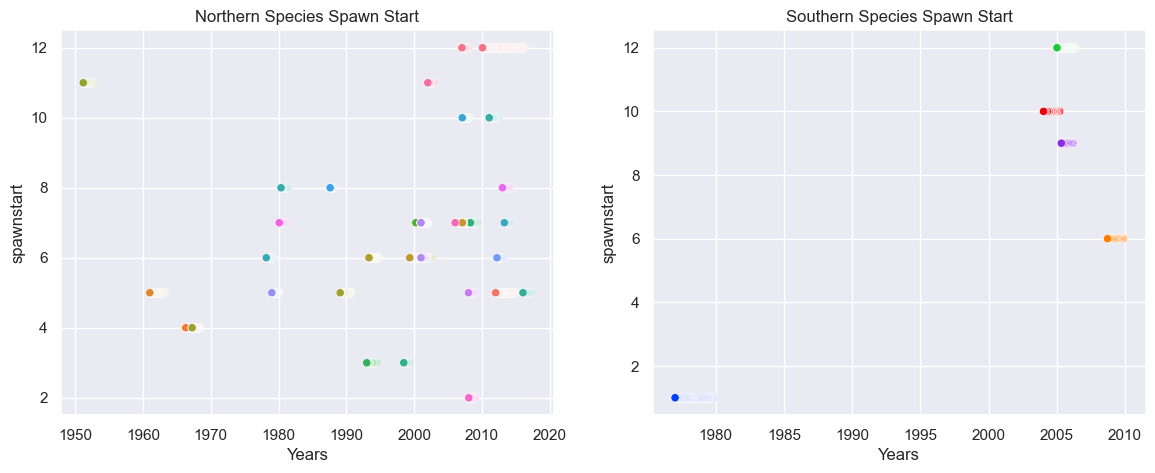

In [37]:
sns.set_palette('bright')
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(ax = ax1, data = temp_small_spawn_p[temp_small_spawn_p['Hemisphere'] == 'North'], x = "Accurate Normalized Date", y = "spawnstart", hue = 'Species')
ax1.set_xlabel('Years')
ax1.title.set_text('Northern Species Spawn Start')
ax1.get_legend().set_visible(False)

sns.scatterplot(ax = ax2, data = temp_small_spawn_p[temp_small_spawn_p['Hemisphere'] == 'South'], x = "Accurate Normalized Date", y = "spawnstart", hue = 'Species')
ax2.set_xlabel('Years')
ax2.title.set_text('Southern Species Spawn Start')
ax2.get_legend().set_visible(False);

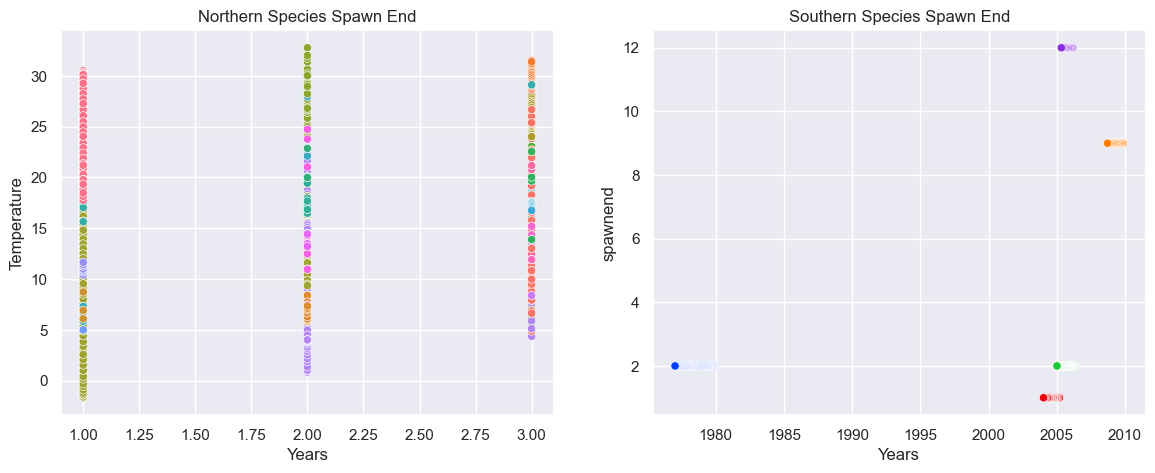

In [39]:
sns.set_palette('bright')
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(ax = ax1, data = temp_small_spawn_p, x = "Spawn Len 1", y = "Temperature", hue = 'Species')
ax1.set_xlabel('Spawn Len 1')
ax1.title.set_text('Northern Species Spawn End')
ax1.get_legend().set_visible(False)

sns.scatterplot(ax = ax2, data = temp_small_spawn_p[temp_small_spawn_p['Hemisphere'] == 'South'], x = "Accurate Normalized Date", y = "spawnend", hue = 'Species')
ax2.set_xlabel('Years')
ax2.title.set_text('Southern Species Spawn End')
ax2.get_legend().set_visible(False);

$H_{0}$: If there is higher temperatures, the species will have a longer spawning period.

$H_{A}$: If there is lower temperatures, the species will have a shorter spawning period.

In [391]:
correlation_temp_df = clams_temp_small.groupby('Species')[['Temperature', 'Spawn Len 1']].min()
correlation_temp_max = clams_temp_small.groupby('Species')['Temperature'].max()
correlation_temp_min = clams_temp_small.groupby('Species')['Temperature'].min()
correlation_temp_df['Temperature'] = correlation_temp_max - correlation_temp_min

temp_corr = sc.stats.pearsonr(correlation_temp_df['Temperature'], correlation_temp_df['Spawn Len 1'])
print("Pearson's Coefficient:",  temp_corr[0])
print("Two Tailed P-value:", temp_corr[1])

Pearson's Coefficient: -0.21437598989845985
Two Tailed P-value: 0.06476114614542464


## Let's Look at How Chlorophyll and Salinity affect it as well

In [361]:
chl_small = clams2_fix[clams2_fix["Chlorophyll"] != 0]
print(chl_small.shape)
print("Unique Species:", len(chl_small['Species'].unique()))
chl_small.head(3)

(1267, 34)
Unique Species: 27


,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date
10,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.000008
13,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.001345
16,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.004465


/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


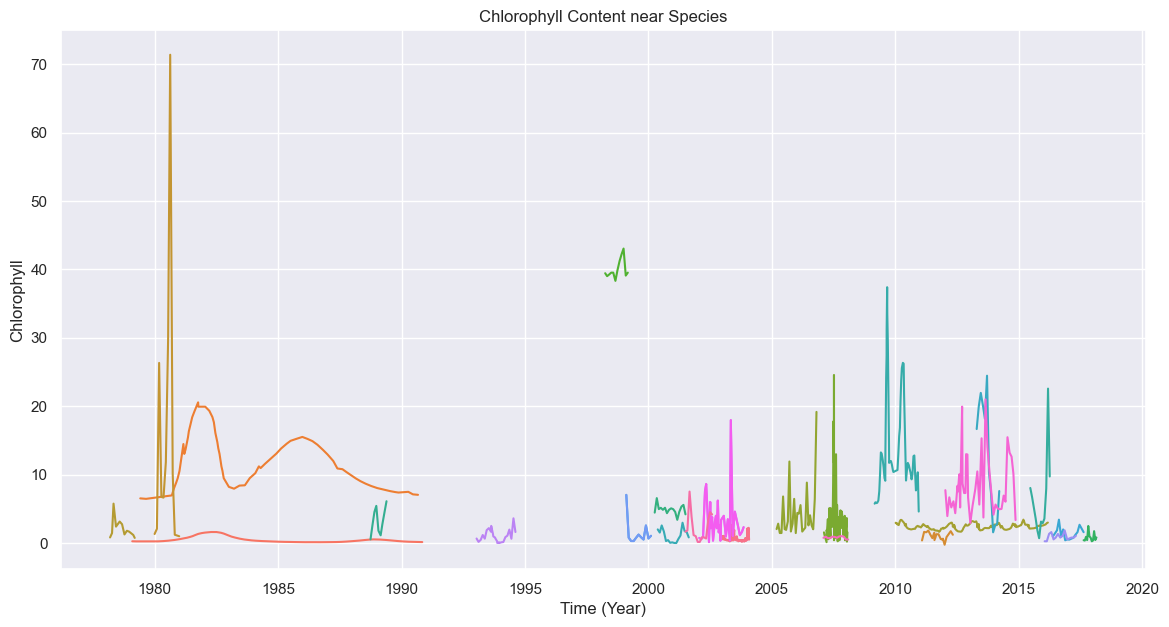

In [392]:
sns.set_palette('pastel')
f, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data = chl_small, x = 'Accurate Normalized Date', y = 'Chlorophyll', hue = "Species")
ax.title.set_text('Chlorophyll Content near Species')
plt.xlabel('Time (Year)')
plt.ylabel('Chlorophyll');
ax.get_legend().set_visible(False)
plt.savefig('CHL_time.png');

Let's consider that these organisms are filter feeders and will benefit with larger amounts of micro-organisms existing in the water. Therefore, looking to see how much bigger the spawning periods between the two groups will show if it has statistical significance.

$H_{0}$: If there is more chlorophyll present, the species will have a longer spawning period.

$H_{A}$: If there is more chlorophyll present, the species will have a shorter spawning period.

In [363]:
chl_corr = sc.stats.pearsonr(chl_small['Chlorophyll'], chl_small['Spawn Len 1'])
print("Pearson's Coefficient:",  chl_corr[0])
print("Two Tailed P-value:", chl_corr[1])

Pearson's Coefficient: 0.35283789561211
Two Tailed P-value: 1.9035803090333913e-38


As we can see, there is no direct correlation between the Spawn Length and Chlorophyll content in the ocean. However, I do want to see if the average spawn length was larger for species with high chlorophyll content.

In [364]:
print(chl_small.shape)
chl_small.head()

(1267, 34)


,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date
10,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.000008
13,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.001345
16,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.004465
18,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.006301
22,3,Ahn et al 2003,Laternula elliptica,"Marian Cove, Antarctica",-62,13.0,-58,47.0,11.0,3.0,...,0,1,Antarctica,South,4,0,0,Temperate,2003,2003.014560


Preparing the Chlorophyll data to create correlations:

In [365]:
chl_species = chl_small[chl_small["Chlorophyll"] >= 20]['Species'].unique().tolist()
index = []
hchl = chl_species.copy()
for i in range(len(chl_small)):
    if chl_small.iloc[i, 2] in hchl:
        index.append(i)
        hchl.remove(chl_small.iloc[i, 2])
high_chl = chl_small.iloc[index, :]
high_chl = high_chl.loc[:, ["Species", 'spawnstart', 'spawnend', 'Spawn Len 1']]
high_chl.loc[:, 'Type'] = ['Chl values peak > 20'] * len(high_chl)


mask = chl_small['Species'].isin(chl_species)
low_chl = chl_small[~mask]
chl_species2 = low_chl['Species'].unique().tolist()
index = []
lchl = chl_species2.copy()
for i in range(len(chl_small)):
    if chl_small.iloc[i, 2] in lchl:
        index.append(i)
        lchl.remove(chl_small.iloc[i, 2])
low_chl = chl_small.iloc[index, :]
low_chl = low_chl.loc[:, ["Species", 'spawnstart', 'spawnend', 'Spawn Len 1']]
low_chl.loc[:, 'Type'] = ['Chl values peak < 20'] * len(low_chl)

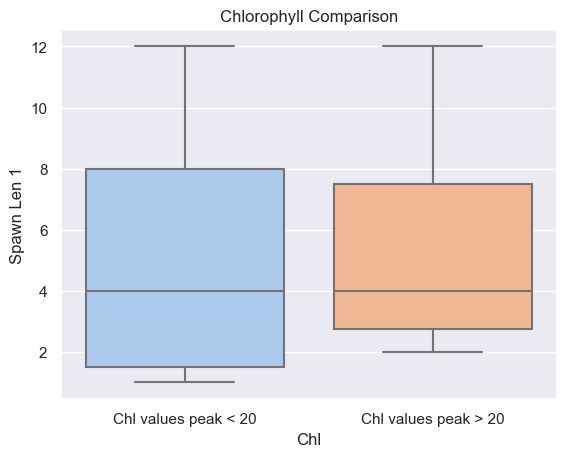

In [366]:
boxplot_chl_df = pd.concat([low_chl, high_chl])
sns.set_palette('pastel')
f, ax = plt.subplots()

sns.boxplot(data = boxplot_chl_df, x = "Type", y = "Spawn Len 1")
ax.set_xlabel('Chl')
ax.title.set_text('Chlorophyll Comparison')

In [367]:
sal_small = clams2_fix[clams2_fix["Salinity"] != 0]
print(sal_small.shape)
print("Unique Species:", len(sal_small['Species'].unique()))
sal_small.head(3)

(1734, 34)
Unique Species: 27


,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date
0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,4,1,India,North,6,0,0,Tropical,1953,1957.0
1,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,5,1,India,North,6,0,0,Tropical,1953,1958.0
2,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,8.0,...,6,1,India,North,6,0,0,Tropical,1953,1959.0


In [368]:
siteid_reset = sal_small['SiteID'].unique()
siteid_curr = [str(x) for x in range(len(sal_small['SiteID'].unique()))]
it_worked = {siteid_reset[i]: siteid_curr[i] for i in range(len(siteid_curr))}
id = []
for i in range(len(sal_small)):
    id.append(it_worked[sal_small.iloc[i, 0]])
sal_small.loc[:, 'SiteID2'] = id

/var/folders/qs/b1lv2m654dj559w51ptt67000000gn/T/ipykernel_13835/2779153204.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal_small.loc[:, 'SiteID2'] = id


/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kenneth/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


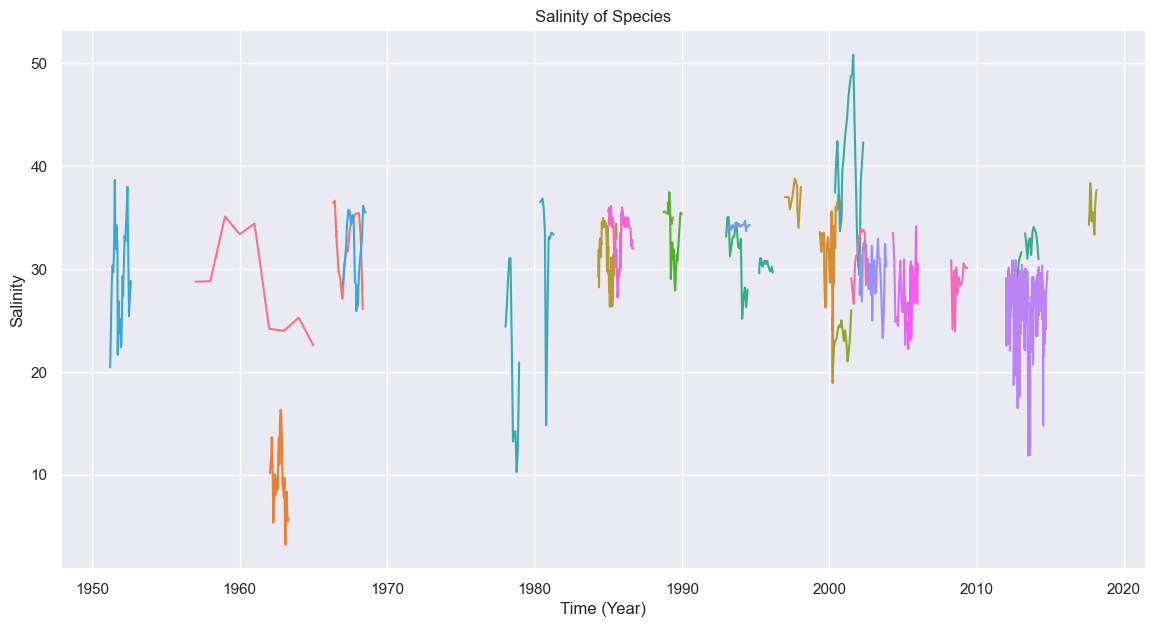

In [394]:
sns.set_palette('bright')
f, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(data = sal_small, x = 'Accurate Normalized Date', y = 'Salinity', hue = "SiteID2")
ax.title.set_text('Salinity of Species')
plt.xlabel('Time (Year)')
plt.ylabel('Salinity');
ax.get_legend() .set_visible(False)
plt.savefig('SAL_time.png');

Salinity in the water directly affects the salinity in the clam's blood. Therefore, such changes in the clam's environment should not only affect its behavior, but also it's reproduction and how effectly it can. with larger fluctiations in the salinity, I predict it would be outside the clam's comfort range to reproduce

$H_{0}$: If there is a higher fluctation of salinity, the species will have a longer spawning period.

$H_{A}$: If there is a lower fluctation of salinity, the species will have a shorter spawning period.

In [370]:
sal_small_min = sal_small.groupby('SiteID2').min()
sal_small_max = sal_small.groupby('SiteID2').max()
sal_small_graph = pd.concat([sal_small_min, sal_small_max])
sal_small_graph = sal_small_graph.sort_index()
flucs = {}
for i in range(0, len(sal_small_graph), 2):
    fluc = np.abs(sal_small_graph.iloc[i+1, 19] - sal_small_graph.iloc[i, 19])
    flucs[sal_small_graph.iloc[i, 0]] = fluc

id = []
for i in range(len(sal_small_graph)):
    id.append(flucs[sal_small_graph.iloc[i, 0]])
sal_small_graph.loc[:, 'SalFluc'] = id
sal_small_graph = sal_small_graph.reset_index()
sal_small_graph.head(2)

,SiteID2,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,...,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date,SalFluc
0,0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,...,1,India,North,6,0,0,Tropical,1953,1957.0,12.537032
1,0,1,Abraham 1953,Meretrix casta,India,13,1.0,80,16.0,2.0,...,1,India,North,6,0,0,Tropical,1953,1965.0,12.537032


In [371]:
sal_corr = sc.stats.pearsonr(sal_small_graph['SalFluc'], sal_small_graph['Spawn Len 1'])
print("Pearson's Coefficient:",  sal_corr[0])
print("Two Tailed P-value:", sal_corr[1])

Pearson's Coefficient: -0.061158996515178615
Two Tailed P-value: 0.6604292255611206


Shows there is no real correlation between the two variables, let's look and see if overtime salinity level fluctuations increase.

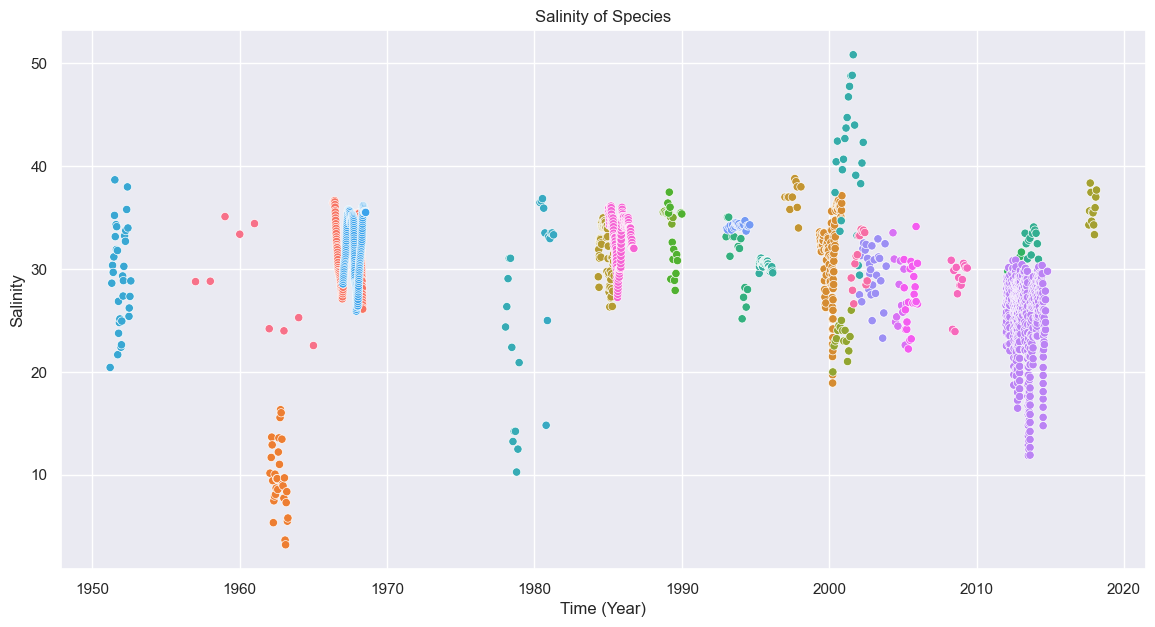

In [395]:
sns.set_palette('bright')
f, ax = plt.subplots(figsize = (14, 7))

sns.scatterplot(data = sal_small, x = 'Accurate Normalized Date', y = 'Salinity', hue = 'SiteID2')
ax.title.set_text('Salinity of Species')
plt.xlabel('Time (Year)')
plt.ylabel('Salinity')
plt.legend().set_visible(False);

In [373]:
sal_corr2 = sc.stats.pearsonr(sal_small['Salinity'], sal_small['Spawn Len 1'])
print("Pearson's Coefficient:",  sal_corr2[0])
print("Two Tailed P-value:", sal_corr2[1])

Pearson's Coefficient: 0.2516819817692289
Two Tailed P-value: 1.847478039792355e-26


In [374]:
a = sal_small.copy()
def accurate_date(data):
    date = []
    for i in range(len(data)):
        year = int(data.iloc[i, 33] // 1)
        month = int((data.iloc[i, 33] % 1) * 12 // 1 + 1)
        day = int((data.iloc[i, 33] % 1) * 12 % 1 * 30 // 1 + 1)
        feb = int((data.iloc[i, 33] % 1) * 12 % 1 * 28 // 1 + 1)
        if day < 10 and feb < 10:
            day = '0' + str(day)
            feb = '0' + str(feb)
        else:
            day = str(day)
            feb = str(feb)
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
        if month == '02':
            date.append(feb+ "-" +month+ "-" +str(year))
        else:
            date.append(day+ "-" +month+ "-" +str(year))
    data['Accurate Date'] = date
    return data
clams2_fix = accurate_date(clams2_fix)

## Bivalve Reproduction based on Family

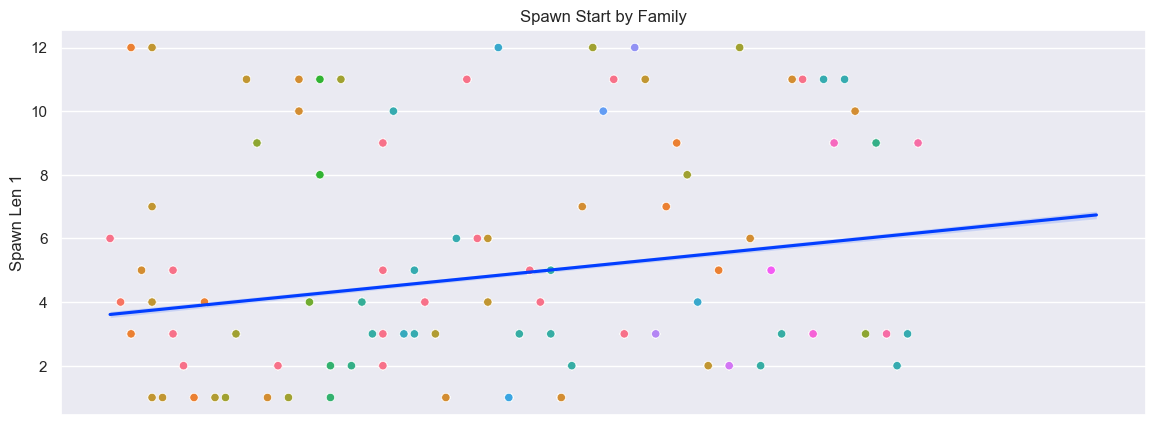

In [419]:

nums_fam = []
abc = {}
count = 0
for i in range(len(clams2_fix)):
    if clams2_fix.iloc[i, 0] not in abc:
        abc[clams2_fix.iloc[i, 0]] = count
        nums_fam.append(count)
        count += 1
    else:
        nums_fam.append(abc[clams2_fix.iloc[i, 0]])
clams2_fix2 = clams2_fix.copy()
clams2_fix2['Species'] = nums_fam

sns.set_palette('bright')
f, ax1 = plt.subplots(figsize=(14, 5))

sns.regplot(data=clams2_fix2, x="Species", y="Spawn Len 1", scatter=False)
sns.scatterplot(data = clams2_fix, x = "Species", y = "Spawn Len 1", hue = 'Family')
ax1.title.set_text('Spawn Start by Family')
ax1.get_legend().set_visible(False)
ax1.get_xaxis().set_visible(False)
plt.savefig('Spawn_Family.png')

In [409]:
family_len = clams2_fix.groupby('Species')[['Family', 'Spawn Len 1', 'Hemisphere']].first()
family_len
nums_fam = []
abc = {}
count = 0
for i in range(len(family_len)):
    if family_len.iloc[i, 0] not in abc:
        abc[family_len.iloc[i, 0]] = count
        nums_fam.append(count)
        count += 1
    else:
        nums_fam.append(abc[family_len.iloc[i, 0]])
family_len['Family'] = nums_fam
family_len_n = family_len[family_len['Hemisphere'] == 'North']
family_len_s = family_len[family_len['Hemisphere'] == 'South']
family_len.head()

,Family,Spawn Len 1,Hemisphere
Species,,,
Acanthocardia tuberculata,0,2,North
Aequipecten opercularis,1,1,North
Anadara antiquata,2,11,North
Anadara ovalis,2,11,North
Anadara trapezia,2,6,South


In [412]:
family_cor = sc.stats.pearsonr(family_len['Family'], family_len['Spawn Len 1'])
print("Pearson's Coefficient:",  sal_corr[0])
print("Two Tailed P-value:", sal_corr[1])

Pearson's Coefficient: -0.061158996515178615
Two Tailed P-value: 0.6604292255611206


### Let's add more features to make it easier for the model

In [466]:
clams2

,SiteID,Study,Species,Locality,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,...,Normalized Date,Chlorophyll,Salinity,Temperature,Family,Month,Day,Year,NumPeaks,Country
0,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,4.000000,0.0,28.783536,0.000,Veneridae,48,1460,4,1,Adyar river mouth
1,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,5.000000,0.0,28.819698,0.000,Veneridae,60,1825,5,1,Adyar river mouth
2,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,6.000000,0.0,35.105508,0.000,Veneridae,72,2190,6,1,Adyar river mouth
3,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,7.000000,0.0,33.390196,0.000,Veneridae,84,2555,7,1,Adyar river mouth
4,1,Abraham 1953,Meretrix casta,Adyar river mouth,13,1.0,80,16.0,2.0,8.0,...,8.000000,0.0,34.424729,0.000,Veneridae,96,2920,8,1,Adyar river mouth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9624,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.582143,0.0,0.000000,30.868,Pinnidae,6,212,0,1,Mexico
9625,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.664286,0.0,0.000000,29.865,Pinnidae,7,242,0,1,Mexico
9626,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.832143,0.0,0.000000,25.898,Pinnidae,9,303,0,1,Mexico
9627,343,Ceballos-Vazquez et al 2000,Pinna rugosa,"Bahia Conception, BCS, Mexico",26,29.0,-111,37.0,3.0,12.0,...,0.917857,0.0,0.000000,21.254,Pinnidae,11,335,0,1,Mexico


In [467]:
print(clams2_fix.shape)
clams_ml = clams2_fix.loc[:, ['SiteID', 'Study', 'Species', 'LatDeg', 'LatMin', 'LongDeg','LongMin', 'spawnstart', 
       'spawnend', 'peak1', 'spawnstart2', 'spawnend2', 'peak2', 'spawnstart3',
       'spawnend3', 'peak3', 'Normalized Date', 'Chlorophyll', 'Salinity', 
       'Temperature', 'Family', 'Month', 'Day', 'Year', 'NumPeaks', 'Country',
       'Hemisphere', 'Spawn Len 1', 'Spawn Len 2', 'Spawn Len 3', 'Lat Zones',
       'Start Year', 'Accurate Normalized Date']]
clams_ml.head(2)

(9379, 35)


,SiteID,Study,Species,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,peak1,...,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date
0,1,Abraham 1953,Meretrix casta,13,1.0,80,16.0,2.0,8.0,7.0,...,4,1,India,North,6,0,0,Tropical,1953,1957.0
1,1,Abraham 1953,Meretrix casta,13,1.0,80,16.0,2.0,8.0,7.0,...,5,1,India,North,6,0,0,Tropical,1953,1958.0


In [468]:
fix = clams_ml.groupby('SiteID').agg({  'Study': 'first', 
                                        'Species': 'first',
                                        'LatDeg': 'first', 
                                        'LatMin': 'first', 
                                        'LongDeg': 'first',
                                        'LongMin': 'first',
                                        'spawnstart': 'first', 
                                        'spawnend': 'first', 
                                        'peak1': 'first', 
                                        'spawnstart2': 'first',
                                        'spawnend2': 'first',
                                        'peak2': 'first', 
                                        'spawnstart3': 'first', 
                                        'spawnend3': 'first', 
                                        'peak3': 'first',
                                        'Normalized Date': 'mean', 
                                        'Chlorophyll': 'mean', 
                                        'Salinity': 'mean', 
                                        'Temperature': 'mean', 
                                        'Family': 'first',
                                        'Month': 'mean', 
                                        'Day': 'mean', 
                                        'Year': 'mean', 
                                        'NumPeaks': 'first', 
                                        'Country': 'first', 
                                        'Hemisphere': 'first',
                                        'Spawn Len 1': 'first', 
                                        'Spawn Len 2': 'first', 
                                        'Spawn Len 3': 'first', 
                                        'Lat Zones': 'first', 
                                        'Start Year': 'first',
                                        'Accurate Normalized Date': 'mean'
                                       })
print(fix.shape)
fix.head(3)

(95, 32)


,Study,Species,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,peak1,spawnstart2,...,Year,NumPeaks,Country,Hemisphere,Spawn Len 1,Spawn Len 2,Spawn Len 3,Lat Zones,Start Year,Accurate Normalized Date
SiteID,,,,,,,,,,,,,,,,,,,,,
1,Abraham 1953,Meretrix casta,13,1.0,80,16.0,2.0,8.0,7.0,0.0,...,8.000000,1,India,North,6,0,0,Tropical,1953,1961.000000
3,Ahn et al 2003,Laternula elliptica,-62,13.0,-58,47.0,11.0,3.0,1.0,0.0,...,0.152797,1,Antarctica,South,4,0,0,Temperate,2003,2003.571657
4,Alagarswami 1966,Donax faba,9,15.0,79,8.0,4.0,7.0,6.0,11.0,...,0.841549,2,India,North,3,1,0,Tropical,1966,1967.297543


In [469]:
#Start and End data (also made it worse)
start_norm_date = clams_ml.groupby('SiteID')['Accurate Normalized Date'].min()
fix['Start Norm Date'] = start_norm_date
last_norm_date = clams_ml.groupby('SiteID')['Accurate Normalized Date'].max()
fix['End Norm Date'] = last_norm_date

#Fluctation data (made it worse...)
sal_max = clams_ml.groupby('SiteID')['Salinity'].max()
sal_min = clams_ml.groupby('SiteID')['Salinity'].min()
sal_fluc = sal_max - sal_min
fix['Salinity Fluctuation'] = sal_fluc
fix['Salinity Max'] = sal_max
fix['Salinity Min'] = sal_min
chl_max = clams_ml.groupby('SiteID')['Chlorophyll'].max()
chl_min = clams_ml.groupby('SiteID')['Chlorophyll'].min()
chl_fluc = chl_max - chl_min
fix['Chlorophyll Fluctuation'] = chl_fluc
temp_max = clams_ml.groupby('SiteID')['Temperature'].max()
temp_min = clams_ml.groupby('SiteID')['Temperature'].min()
temp_fluc = temp_max - temp_min
fix['Temperature Fluctuation'] = temp_fluc
fix['Temperature Max'] = sal_max
fix['Temperature Min'] = sal_min

#Log data


fix.head(3)

,Study,Species,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,peak1,spawnstart2,...,Accurate Normalized Date,Start Norm Date,End Norm Date,Salinity Fluctuation,Salinity Max,Salinity Min,Chlorophyll Fluctuation,Temperature Fluctuation,Temperature Max,Temperature Min
SiteID,,,,,,,,,,,,,,,,,,,,,
1,Abraham 1953,Meretrix casta,13,1.0,80,16.0,2.0,8.0,7.0,0.0,...,1961.000000,1957.000000,1965.000000,12.537032,35.105508,22.568477,0.000000,0.000000,35.105508,22.568477
3,Ahn et al 2003,Laternula elliptica,-62,13.0,-58,47.0,11.0,3.0,1.0,0.0,...,2003.571657,2003.000008,2004.087893,0.000000,0.000000,0.000000,2.688417,4.004642,0.000000,0.000000
4,Alagarswami 1966,Donax faba,9,15.0,79,8.0,4.0,7.0,6.0,11.0,...,1967.297543,1966.319370,1968.343153,36.649695,36.649695,0.000000,0.000000,31.400861,36.649695,0.000000


## Time to Random Forests

In [470]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from scipy.stats import randint

In [475]:
len(fix.columns), fix.columns

(41,
 Index(['Study', 'Species', 'LatDeg', 'LatMin', 'LongDeg', 'LongMin',
        'spawnstart', 'spawnend', 'peak1', 'spawnstart2', 'spawnend2', 'peak2',
        'spawnstart3', 'spawnend3', 'peak3', 'Normalized Date', 'Chlorophyll',
        'Salinity', 'Temperature', 'Family', 'Month', 'Day', 'Year', 'NumPeaks',
        'Country', 'Hemisphere', 'Spawn Len 1', 'Spawn Len 2', 'Spawn Len 3',
        'Lat Zones', 'Start Year', 'Accurate Normalized Date',
        'Start Norm Date', 'End Norm Date', 'Salinity Fluctuation',
        'Salinity Max', 'Salinity Min', 'Chlorophyll Fluctuation',
        'Temperature Fluctuation', 'Temperature Max', 'Temperature Min'],
       dtype='object'))

In [472]:
X = fix.loc[:, fix.columns != 'Spawn Len 1']
y = fix['Spawn Len 1']

ohe = OneHotEncoder(sparse_output=False)
# le = LabelEncoder()

categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# X_train[categorical_columns] = X_train[categorical_columns].apply(lambda col: le.fit_transform(col))

ohe_data = ohe.fit_transform(X[categorical_columns])
ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_columns)).set_index(X.index)

ml = pd.concat([X, ohe_df], axis=1)

X = ml.drop(categorical_columns, axis=1)
display(y)
X

SiteID
1      6
3      4
4      3
5      5
6      1
      ..
335    9
336    3
340    2
342    3
343    9
Name: Spawn Len 1, Length: 95, dtype: int64

,LatDeg,LatMin,LongDeg,LongMin,spawnstart,spawnend,peak1,spawnstart2,spawnend2,peak2,...,Country_Tunisia,Country_Turkey,Country_United Kingdom,"Country_Washington, USA",Hemisphere_North,Hemisphere_South,Lat Zones_Boreal,Lat Zones_Subtropical,Lat Zones_Temperate,Lat Zones_Tropical
SiteID,,,,,,,,,,,,,,,,,,,,,
1,13,1.0,80,16.0,2.0,8.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-62,13.0,-58,47.0,11.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,9,15.0,79,8.0,4.0,7.0,6.0,11.0,12.0,12.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,36,52.0,-76,18.0,6.0,11.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,40,42.0,-8,40.0,6.0,7.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,26,29.0,-111,37.0,4.0,1.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
336,-40,53.0,-65,4.0,11.0,2.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
340,32,47.0,130,36.0,7.0,9.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((76, 264), (19, 264), (76,), (19,))

In [474]:
rf = RandomForestClassifier()
# X, y = make_classification(n_samples=100, n_features=142,
#                             n_informative=2, n_redundant=0,
#                             random_state=69, shuffle=False)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3157894736842105


In [435]:
len(clams2['Family'].unique())

26